## Overview

To continue our analysis, we will use different decision tree methods to predict which subreddit our reddit text data belongs to. 

First, we will use a random classifier as a baseline model. Then, we will use a simple decision tree classifier to predict the subreddit. Finally, we will use a random forest classifier to predict the subreddit.

## Methods

Before we start the analysis, we will give a brief overview of the methods we will use.

### Decision Tree

A decision tree is a simple method for both classification and regression. Decision trees are non-parametric models that are very easy to implement, understand, and visualize. Decision tress are often chosen for their high interpretability, since they are easy to understand and provide transparency into how the model makes predictions. 

Decision trees work by developing a sequential set of rules that are used to predict the target variable. For a numeric feature, a decision tree starts by looking at all the data and finding the optimal feature and split point to minimize the Gini index. The Gini index is a measure of node purity, indictating whether all the observations in the node fall into the same class or result in mixed classes. This means the data will be split into observations where the given feature value is less than the split point and observations where the given feature value is more than the split point. For a categorical feature, the decision tree will split the data into observations based on the categories of the feature, again using the sum of squared errors to find a split point. This process is repeated recursively, continually subdividing the nodes, until a stopping point is reached. When the stopping point is met, each leaf node will represent a class in our target variable. This means that when we want to make a prediction, we will start at the root node and follow the rules until we reach a leaf node, which will be our prediction.

When implementing a decision tree, there are a few hyperparameters that can be tuned for better performance. The maximum depth of the tree can be tuned to find the optimal number of splits. The minimum number of samples required to split an internal node can also be tuned, preventing the tree from splitting nodes with too few observations. The metric used to measure the quality of a split can also be tuned, but we will use the default metric for classification, which is the Gini index.

While fitting a single decision tree to the data is easy, fast, and highly interpretable, it has significant drawbacks. Decision trees are prone to overfitting, especially without tuning the hyperparameters or pruning. Decision trees are also unstable, meaning that small changes in the data can lead to large changes how the model is built and makes predictions. Decision trees also make highly local predictions since they work much like a large piecewise function, meaning they cannot extrapolate well to new data.

### Random Forest

Random forest is an ensemble method that combines multiple decision trees into one model that performs better than an individual tree. Random forests are effective at combatting the weaknesses of single decision trees. They tend to have better performance and are less prone to overfitting. They are also more stable because predictions come from an ensemble of trees rather than one single tree.

Random forest work by first creating a data set sample from the original data set, with replacement. This new bootstrapped data set is the same size as the initial data set. Next, a decision tree is fit to the bootstrapped data set. However, at each node, a random subset of features is selected. Then, the tree is built in te same way as the normal decision tree, finding an optimal split point and minimizing the Gini index. This process is repeated for many trees, each turning out different due to the bootstrapping and random feature selection. Finally, the predictions from each tree are averaged to get the final prediction, creating an ensemble learner.

When implementing a random forest, there are hyperparameters that can be tuned to improve performance. The number of predictors chosen at each split can be tuned. Typically, the best number is the square root of the total number of predictors. The same hyperparameters as the decision tree can also be tuned, such as the maximum depth of the tree and the minimum number of samples required to split an internal node.

## Data

Our data will be a collection of posts from three subreddits: r/Psychosis, r/Schizophrenia, and r/weed. Our goal is to predict which one of the subreddits the text belongs in using a decision tree and random forest.

We will use ROC AUC, sensitivity, specificity, and accuracy to evaluate the performance of our models.

In [6]:
# Import and clean the data (repeated from Naive Bayes)

import pandas as pd
import numpy as np

reddit_text = pd.read_csv('../../../data/clean_data/reddit_cleaned_text.csv')

reddit_text.dropna(inplace=True)
reddit_text['label'] = reddit_text['label'].replace(['weed', 'Psychosis', 'schizophrenia'], [0, 1, 2])
y = reddit_text['label'].to_numpy()

from sklearn.feature_extraction.text import CountVectorizer

def vectorize(corpus,MAX_FEATURES):
    vectorizer=CountVectorizer(max_features=MAX_FEATURES,stop_words="english")   
    # RUN COUNT VECTORIZER ON OUR COURPUS 
    Xs  =  vectorizer.fit_transform(corpus)   
    X=np.array(Xs.todense())
    #CONVERT TO ONE-HOT VECTORS (can also be done with binary=true in CountVectorizer)
    maxs=np.max(X,axis=0)
    return (np.ceil(X/maxs),vectorizer.vocabulary_)

(x,vocab0)=vectorize(reddit_text['text'],MAX_FEATURES=10000)

vocab1 = dict([(value, key) for key, value in vocab0.items()])
df2=pd.DataFrame(x)
s = df2.sum(axis=0)
df2=df2[s.sort_values(ascending=False).index[:]]
i1=0
vocab2={}
for i2 in list(df2.columns):
    vocab2[i1]=vocab1[int(i2)]
    i1+=1

df2.columns = range(df2.columns.size)

x=df2.to_numpy()

## Implementation

Now that we understand the methods we will use, we can start the analysis. We have already loaded in our data. We will split our data into training and text sets, with 80% of the data in the training set and 20% in the test set.

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=371)

### Baseline Model

The baseline model will be a random classifier. This model will randomly predict one of the three subreddits for each observation. We will use this model to compare the performance of our decision tree and random forest models.

In [8]:
import random
random.seed(371)
rand_pred = [random.randint(0, 2) for _ in range(len(y_test))]

In [13]:
# Evaluation the random model
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

rand_acc = accuracy_score(y_test, rand_pred)
rand_prf = precision_recall_fscore_support(y_test, rand_pred, average='macro')
rand_conf = confusion_matrix(y_test, rand_pred)
print(f'Accuracy: {rand_acc}')
print(f'Precision: {rand_prf[0]}')
print(f'Recall: {rand_prf[1]}')
print(f'F1: {rand_prf[2]}')
print(f'Confusion Matrix: \n{rand_conf}')
print(classification_report(y_test, rand_pred))

Accuracy: 0.3207070707070707
Precision: 0.3206225421176528
Recall: 0.3206821822652616
F1: 0.3206434421644277
Confusion Matrix: 
[[618 678 685]
 [683 622 666]
 [658 665 665]]
              precision    recall  f1-score   support

           0       0.32      0.31      0.31      1981
           1       0.32      0.32      0.32      1971
           2       0.33      0.33      0.33      1988

    accuracy                           0.32      5940
   macro avg       0.32      0.32      0.32      5940
weighted avg       0.32      0.32      0.32      5940



As expected, the baseline model performs very poorly, with an accuracy of only 32.1%. This is because the model is randomly guessing the subreddit for each observation, so it is only correct about 1/3 of the time.

### Decision Tree

Next, we will be using a decision tree to predict the subreddit label. We expect only moderate performance, since decision trees are prone to overfitting and are unstable. We will tune for the maximum depth of the tree and the minimum number of samples required to split an internal node.

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from tqdm import tqdm

# Tune the hyperparameters
results = {}
for max_depth in tqdm(range(1, 20)):
    for min_samples_split in range(2, 20):
        decision_tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
        decision_tree.fit(x_train, y_train)
        y_pred = decision_tree.predict(x_test)
        acc = accuracy_score(y_test, y_pred)
        prf = precision_recall_fscore_support(y_test, y_pred, average='macro')
        conf = confusion_matrix(y_test, y_pred)
        results[(max_depth, min_samples_split)] = (acc, prf, conf, decision_tree, y_pred)

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [07:03<00:00, 22.30s/it]


Best max_depth: 19
Best min_samples_split: 19


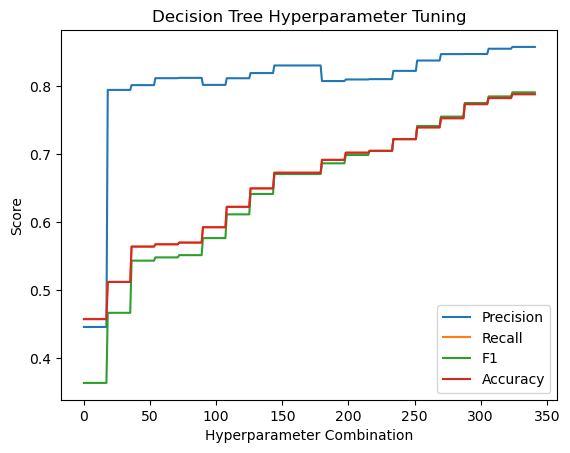

In [45]:
results_df = pd.DataFrame(results).T.reset_index()
results_df.columns = ['max_depth', 'min_samples_split', 'acc', 'prf', 'conf', 'model', 'y_pred']
results_df['acc'] = results_df['acc'].astype(float)

best_max_depth = results_df.sort_values(by='acc', ascending=False).iloc[0]['max_depth']
best_max_depth = int(best_max_depth)
print(f'Best max_depth: {best_max_depth}')
best_min_samples_split = results_df.sort_values(by='acc', ascending=False).iloc[0]['min_samples_split']
best_min_samples_split = int(best_min_samples_split)
print(f'Best min_samples_split: {best_min_samples_split}')

# Plot the hyperparameter tuning results
plt.figure()
plt.plot(results_df['prf'].apply(lambda x: x[0]), label='Precision')
plt.plot(results_df['prf'].apply(lambda x: x[1]), label='Recall')
plt.plot(results_df['prf'].apply(lambda x: x[2]), label='F1')
plt.plot(results_df['acc'], label='Accuracy')
plt.legend()
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Score')
plt.title('Decision Tree Hyperparameter Tuning')
plt.show()

Accuracy: 0.7882154882154883
Precision: 0.8577679568806055
Recall: 0.7883287378592542
F1: 0.7909901039417404
Confusion Matrix: 
[[1981    0    0]
 [ 444 1460   67]
 [ 747    0 1241]]
              precision    recall  f1-score   support

           0       0.62      1.00      0.77      1981
           1       1.00      0.74      0.85      1971
           2       0.95      0.62      0.75      1988

    accuracy                           0.79      5940
   macro avg       0.86      0.79      0.79      5940
weighted avg       0.86      0.79      0.79      5940



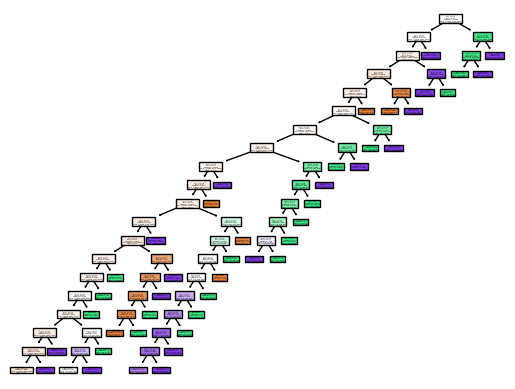

In [43]:
# Fit the best model
decision_tree = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split)
decision_tree.fit(x_train, y_train)

# Evaluate the best model
y_pred = decision_tree.predict(x_test)
acc = accuracy_score(y_test, y_pred)
prf = precision_recall_fscore_support(y_test, y_pred, average='macro')
conf = confusion_matrix(y_test, y_pred)
print(f'Accuracy: {acc}')
print(f'Precision: {prf[0]}')
print(f'Recall: {prf[1]}')
print(f'F1: {prf[2]}')
print(f'Confusion Matrix: \n{conf}')
print(classification_report(y_test, y_pred))

# Plot the best model
plt.figure()
plot_tree(decision_tree, filled=True, class_names=['weed', 'Psychosis', 'schizophrenia'])
plt.show()

Our final decision tree has a maximum depth of 19 and a minimum number of samples required to split an internal node of 19. The accuracy is 0.788, the precision is 0.858, the recall is 0.788, and the F1 score is 0.791. Overall, the model performs fairly well, improving significantly upon the random classifier.

### Random Forest

Finally, we will use a random forest to predict the subreddit label. We expect this model to perform better than the decision tree, since it is an ensemble method that is less prone to overfitting and is more stable. We will tune for the maximum depth of the tree and the minimum number of samples required to split an internal node.

In [46]:
from sklearn.ensemble import RandomForestClassifier

# Tune the hyperparameters
results_rf = {}
for max_depth in tqdm(range(1, 20)):
    for min_samples_split in range(2, 20):
        random_forest = RandomForestClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
        random_forest.fit(x_train, y_train)
        y_pred = random_forest.predict(x_test)
        acc = accuracy_score(y_test, y_pred)
        prf = precision_recall_fscore_support(y_test, y_pred, average='macro')
        conf = confusion_matrix(y_test, y_pred)
        results_rf[(max_depth, min_samples_split)] = (acc, prf, conf, random_forest, y_pred)

100%|██████████| 19/19 [24:11<00:00, 76.42s/it] 


Best max_depth: 19
Best min_samples_split: 6


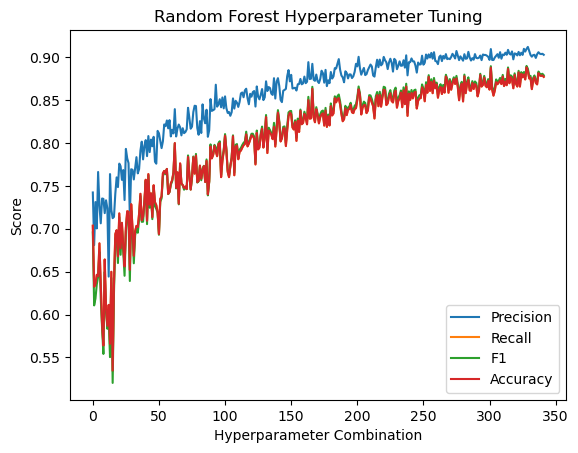

In [47]:
results_rf_df = pd.DataFrame(results_rf).T.reset_index()
results_rf_df.columns = ['max_depth', 'min_samples_split', 'acc', 'prf', 'conf', 'model', 'y_pred']
results_rf_df['acc'] = results_rf_df['acc'].astype(float)

best_max_depth = results_rf_df.sort_values(by='acc', ascending=False).iloc[0]['max_depth']
best_max_depth = int(best_max_depth)
print(f'Best max_depth: {best_max_depth}')
best_min_samples_split = results_rf_df.sort_values(by='acc', ascending=False).iloc[0]['min_samples_split']
best_min_samples_split = int(best_min_samples_split)
print(f'Best min_samples_split: {best_min_samples_split}')

# Plot the hyperparameter tuning results
plt.figure()
plt.plot(results_rf_df['prf'].apply(lambda x: x[0]), label='Precision')
plt.plot(results_rf_df['prf'].apply(lambda x: x[1]), label='Recall')
plt.plot(results_rf_df['prf'].apply(lambda x: x[2]), label='F1')
plt.plot(results_rf_df['acc'], label='Accuracy')
plt.legend()
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Score')
plt.title('Random Forest Hyperparameter Tuning')
plt.show()

In [49]:
# Fit the best model
random_forest = RandomForestClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split)
random_forest.fit(x_train, y_train)

# Evaluate the best model
y_pred = random_forest.predict(x_test)
acc = accuracy_score(y_test, y_pred)
prf = precision_recall_fscore_support(y_test, y_pred, average='macro')
conf = confusion_matrix(y_test, y_pred)
print(f'Accuracy: {acc}')
print(f'Precision: {prf[0]}')
print(f'Recall: {prf[1]}')
print(f'F1: {prf[2]}')
print(f'Confusion Matrix: \n{conf}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8747474747474747
Precision: 0.9067853487001468
Recall: 0.8748031908685326
F1: 0.8776059345763368
Confusion Matrix: 
[[1981    0    0]
 [ 292 1661   18]
 [ 434    0 1554]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1981
           1       1.00      0.84      0.91      1971
           2       0.99      0.78      0.87      1988

    accuracy                           0.87      5940
   macro avg       0.91      0.87      0.88      5940
weighted avg       0.91      0.87      0.88      5940



The final random forest has a maximum depth of 19 and a minimum number of samples required to split an internal node of 6. The accuracy is 0.875, the precision is 0.907, the recall is 0.875, and the F1 score is 0.878. Overall, the model performs very well, improving up the decision tree model by almost 10% in accuracy.

## Results

| Model | Accuracy | Precision | Recall | F1 Score |
| --- | --- | --- | --- | --- |
| Random Baseline | 0.321 | 0.321 | 0.321 | 0.321 |
| Decision Tree | 0.788 | 0.858 | 0.788 | 0.791 |
| Random Forest | 0.875 | 0.907 | 0.875 | 0.878 |

We can see from our final results that the worst model is the random baseline, which is expected since it is randomly guessing the subreddit for each observation. The baseline model has an accuracy of 32.1%, which is exactly what we would expect for random guessing since there are three subreddits with equal numbers of observations.

The single decision tree performs significantly better than the baseline model, with an accuracy of 78.8%. This is expected since the decision tree is able to learn from the data and make predictions based on the features. However, the decision tree is prone to overfitting and is unstable, so it does not perform as well as the random forest. This is in line with our expectations and in contrast with the performance of the regression analysis, where our single decision tree performed better than the random forest.

The random forest performs the best out of all the models, with an accuracy of 87.5%. This is expected since the random forest is an ensemble method that combines many decision trees into one better model. The precision, recall, and F1 score are all better for our random forest than our decision tree, which is also expected. These values are similar to our accuracy, which shows us that the predictions are balanced between all classes.

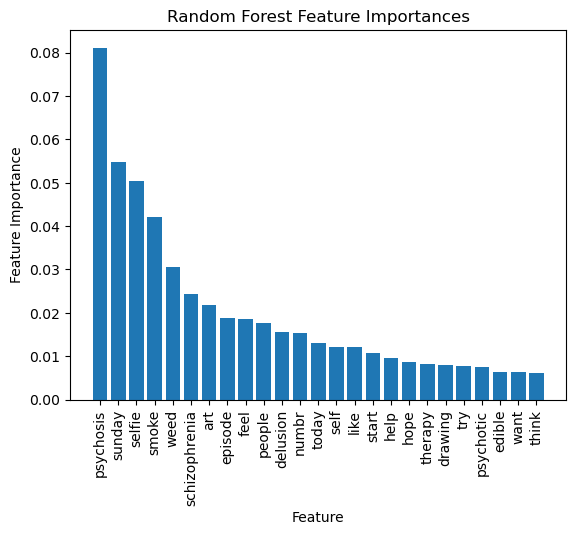

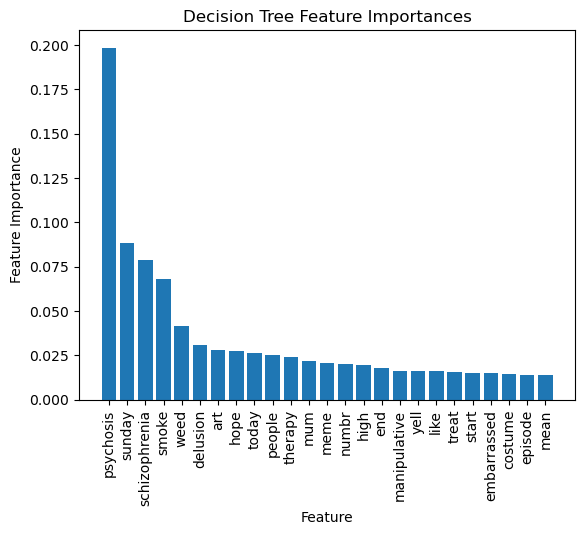

In [59]:
# Visualize the most important features in the random forest model
feature_importances_rf = random_forest.feature_importances_
feature_importances_rf = pd.DataFrame({'feature_importance': feature_importances_rf})
feature_importances_rf['feature'] = feature_importances_rf.index
feature_importances_rf['feature'] = feature_importances_rf['feature'].map(vocab2)
feature_importances_rf = feature_importances_rf.sort_values(by='feature_importance', ascending=False).reset_index(drop=True)

plt.figure()
plt.bar(feature_importances_rf['feature'][:25], feature_importances_rf['feature_importance'][:25])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()

# Visualize the most important features in the decision tree model
feature_importances = decision_tree.feature_importances_
feature_importances = pd.DataFrame({'feature_importance': feature_importances})
feature_importances['feature'] = feature_importances.index
feature_importances['feature'] = feature_importances['feature'].map(vocab2)
feature_importances = feature_importances.sort_values(by='feature_importance', ascending=False).reset_index(drop=True)

plt.figure()
plt.bar(feature_importances['feature'][:25], feature_importances['feature_importance'][:25])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Decision Tree Feature Importances')
plt.show()

Here, we see that for both models, the subeddit names are of very high feature importance. We can also see words that clearly relate to cannabis, such as "smoke", or psychosis, such as "delusion". Some words are more suprising, such as "sunday", "art", and "today".

In the future, I hope to perform a sentiment analysis on this subreddit data to gain a deeper understanding of the public opinions on cannabis usage and its relation to psychosis and schizophrenia.